# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 33) #Установил опцию, чтобы видеть все столбцы
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # Прочитал файл и прописал разделение строк
data.info()
#print(data.shape)
#print(data.describe())
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    return pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])
#missing_data(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

# Вывод

 1. Данные в файле хранятся в виде списка(\t-раздельтель столбцов). 22-а столбца и 23699 строк. Больше чем в половине столбцов есть пропуски. Значения в столбцах в 4-х типах (bool, float64, int64, object)

 2. В значениях столбцов  parks_around3000 и ponds_around3000 пропуски скорее всего говорят об отсутствии парков и прудов в районе 3км

### Шаг 2. Предобработка данных

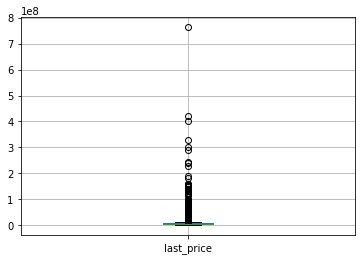

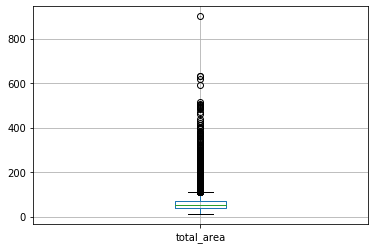

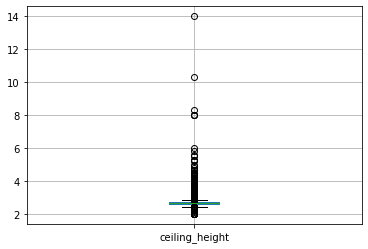

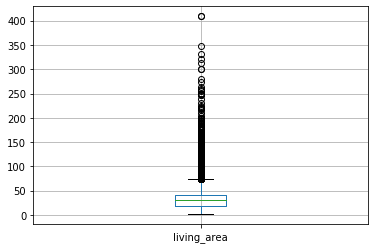

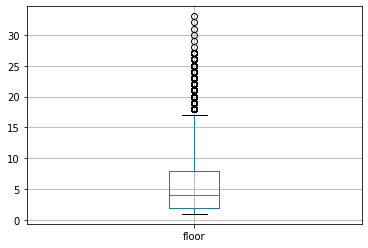

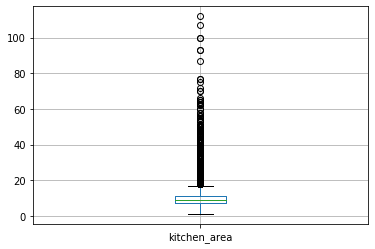

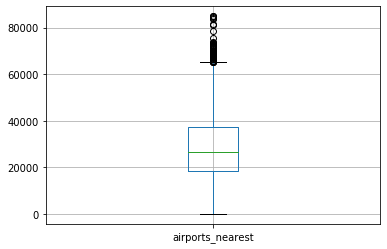

In [ ]:
#1 print(data['total_images'].value_counts()) #1059 без фото
#print(data['last_price'].sort_values().head(20))# Проверил выбросы, min 12190.0 - это ошибка,
#реальная стоимость такой квартиры, больше 10 млн.(отбросил, т.к. одно значение и не влияет)
data['last_price'] = data['last_price'].drop(data[data['last_price']==12190].index, axis = 0) # Удалил min 12190.0
data.boxplot(column='last_price') # В нормальные значения попадают квартиры со стоимостью до 12 млн(много выбросов схлопываю диаграмму) 
plt.show()

#2 print(data['total_area'].sort_values().tail(50))# 900 возможно ошибка
#print(data[data['total_area']==900])# Проверил площадь 900. Последний этаж, 409,7 - пл-дь, похоже пент-хаус и данные верны
data['total_area'] = data['total_area'].astype('int64') #Округлил до целого переводом в целочисленные значения
data.boxplot(column='total_area')
plt.show()
#print(data['total_area'].value_counts().head(50))

#3 print(data['first_day_exposition'].value_counts().head(30))# 368 объявлений 2018-02-01 и пики 09,10,11 в 2017 .. странно

#4 print(data['rooms'].value_counts()) # 197 квартир с 0 в значении комнаты
#print(data[data['rooms']==0].head(10))# Проверил кв-ры с 0 комнат. Везде нет кухни, а из столбцов свободная планировка и
# кварира-студия видно, что это либо одно, либо другое.
data['rooms'] = data['rooms'].replace(0, 1) # Исправил 0 на 1 
data['rooms'] = pd.to_numeric(data['rooms']) #Округлил до целого переводом в целочисленные значения
#5 print(data['ceiling_height'].dropna().sort_values().head(50))# есть значения 1 и 100(удалить), 1.2==2.1 1.75==2.75 
#и есть выбросы 20 и выше, скорее всего неправильно поставили запятую, нужно разделить на 10
data['ceiling_height'] = data['ceiling_height'].drop(data[data['ceiling_height']==1.00].index, axis = 0)
data['ceiling_height'] = data['ceiling_height'].drop(data[data['ceiling_height']==100.00].index, axis = 0)
data['ceiling_height'] = data['ceiling_height'].replace(1.2,2.1)
data['ceiling_height'] = data['ceiling_height'].replace(1.75,2.75)
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<20.00,data['ceiling_height']/10)
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data.boxplot(column='ceiling_height')
plt.show()
#6 print(data['floors_total'].value_counts())# 60 - исправить на 6(т.к. кронштад, там дома низкие),
#52,37- УДАЛИТЬ(опечатка тк кв маленькая и 4,1млн) - опечатки непонятного хар-ра, и всего по одному дому с таким кол-вом эт. 
data['floors_total'] = data['floors_total'].replace(60,6)
data['floors_total'] = data['floors_total'].drop(data[data['floors_total']==37].index, axis = 0)
data['floors_total'] = data['floors_total'].drop(data[data['floors_total']==52].index, axis = 0)
data['floors_total'] = data['floors_total'].fillna(-999) # Заполнил пропуски
data['floors_total'] = data['floors_total'].astype('int64')#Округлил до целого переводом в целочисленные значения
#print(data['floors_total'].value_counts())
#7 print(data['living_area'].value_counts().head(50)) # Для более четкого анализа ОКРУГЛИТЬ до целого
#data['living_area'] = data['living_area'].astype('int64') # Для этого необходимо избавиться от пропусков
#data['living_area_good'] = data['living_area'].ffill().shift()
data['living_area'] = data['living_area'].fillna(data['living_area'].median())# Заполнил пропуски медианой
data['living_area'] = data['living_area'].astype('int64') #Округлил до целого переводом в целочисленные значения
#data['living_area_drop'] = data['living_area'].dropna() # Проверил 4 способа заполенеия пропусков:
#замена на ближнее дает самые низкие искажения в описании столбца(describe).Но если просчитать долю от общей площади, виден сильный перекос
# при замене на медиану или среднюю более сильное искажение в описании+выброс на графике
# В итоке решил не трогать столбец. А если понадобится удалить пропуски
data.boxplot(column='living_area') # Есть выбросы 409, 409.7, 347.5 Проверил - похоже на правду
plt.show()

#8 print(data['floor'].value_counts()) # похоже в Питере только один дом в 35 этажей(сравнил min этого столбца, локация совпала),
#т.к. совпадают все значения по локации для этого дома можно заполнить пропуски в кол-ве парков и расстояния до них
data.boxplot(column='floor')
plt.show()
#9 print(data['kitchen_area'].value_counts().head(50))# ОКРУГЛИТЬ до целого(тоже избавиться от пропусков) 
#data['kitchen_area_good'] = data['kitchen_area'].ffill().shift()
# Так же как в living_area
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data['kitchen_area'] = data['kitchen_area'].astype('int64') #Округлил до целого переводом в целочисленные значения
data.boxplot(column='kitchen_area')
plt.show()

#10 print(data['balcony'].value_counts())# 11519 пропусков, думаю что там балконы отсутствуют и нужно заменить на 0
data['balcony'] = data['balcony'].fillna(0) # Заполнил 0 пропуски
data['balcony'] = data['balcony'].astype('int64') #Округлил до целого переводом в целочисленные значения

#11 print(data['locality_name'].value_counts().head(60)) # Почти 75% квартир в Питере, Кудрово и Мурино повторяются(нужно проверить остальные)
data['locality_name'] = data['locality_name'].str.lower() # привел к нижнему регистру, длч удобства чтения

#12 print(data['airports_nearest'].value_counts().head(60))#37434 21928, 39946 44870 можно группировать дома по локации
#и заполнять пропуски общими данными(высота потолков)
#print(data['ponds_nearest'].value_counts())# так же как с аэропортом, потолки

data.boxplot(column='airports_nearest')
plt.show()
#data.info()



# Вывод

какие пропущенные значения обнаружены;
в чём возможные причины возникновения пропусков;
в каких столбцах потребовалось изменить тип данных и почему;
по какому принципу заполнены пропуски.
1. Обнаружил пропущенные значения в rooms. Чаще всего пропуски встечаются в квартирах свободной планировки или студиях. Заполнил пропуски и нулевые значения 1(единицей). Изменил тип данных на int64 для возможности проводить вычисления со стобцом.
2. Обнаружил пропущенные значения в rooms.

### Шаг 3. Посчитайте и добавьте в таблицу

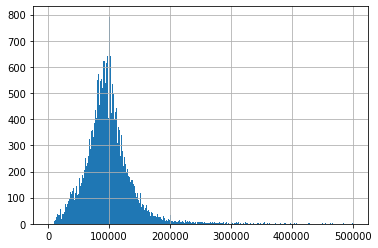

In [ ]:
import matplotlib.pyplot as plt

# Добавим цену квадратного метра
data['square_meter_price'] = data['last_price']/data['total_area']
data['square_meter_price'].hist(bins=300, range=(0,500000))
plt.show()


 - Добавил стоимость кв. метра и построил гистограмму

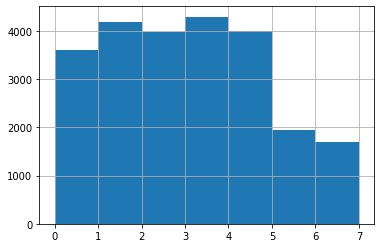

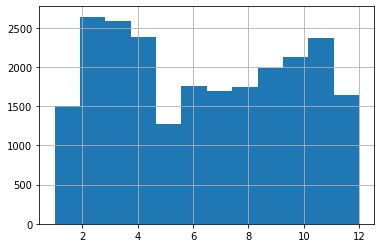

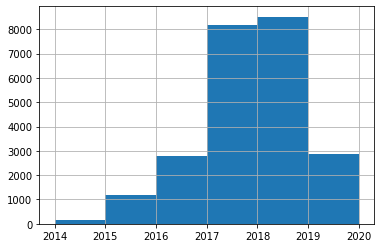

In [ ]:
# День недели, месяц и год публикации
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data['week_day'] = data['first_day_exposition'].dt.weekday
data['week_day'].hist(bins=7, range=(0,7))
plt.show()
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['month'].hist(bins=12, range=(1,12))
plt.show()
data['year'] = data['first_day_exposition'].dt.year
data['year'].hist(bins=6, range=(2014,2020))
plt.show()

- Добавил день недели, месяц и год публикации. Проследил зависимость 

In [ ]:
# Этаж на котором расположена квартира(первый, последний, другой)
#def floor_1(row):
#    if row['floor']==1:
#        return "первый"
#    elif row['floor']==row['floors_total']:
#        return "последний"
#    else:
#        return "другой"
#data['floor_type'] = data.apply(floor_1, axis=1)
#print(data['floor_type'].value_counts())
data['floor_type'] = 'другой'
data['floor_type'] = data['floor_type'].where(data['floor']!=1,'первый')
data['floor_type'] = data['floor_type'].where(data['floor']!=data['floors_total'],'последний')
share_lower = len(data[data['floor_type']=="первый"])/len(data['floor_type'])*100
share_upper = len(data[data['floor_type']=="последний"])/len(data['floor_type'])*100
share_other = len(data[data['floor_type']=="другой"])/len(data['floor_type'])*100
print('Доля квартир на последнем этаже: {:.0f}%'.format(share_upper))
print('Доля квартир на первом этаже: {:.0f}%'.format(share_lower))
print('Доля остальный квартир: {:.0f}%'.format(share_other))


Доля квартир на последнем этаже: 14%
Доля квартир на первом этаже: 12%
Доля остальный квартир: 74%


<font color=blue>**Челендж**: сделать категоризацию по типу этажа методом `where()`. Встроенные методы всегда быстрее собственных функций, что важно для больших сетов.  Сперва можно присвоить всем этажам статус "другой", а затем еще в две строки последовательно поменять его исходя из наших условий.    

- Добавил колонку с первым и последним этажом для оценки их соотношения в выборке

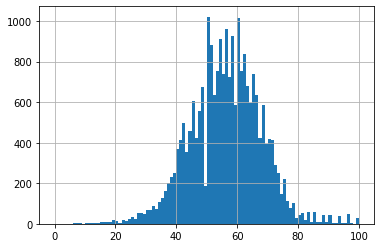

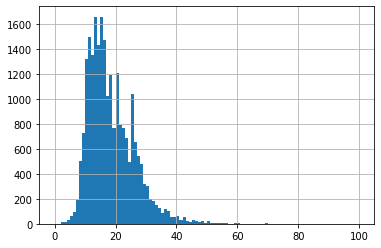

In [ ]:
# Соотношение жилой и общей площади, а также отношение площади кухни к общей(применим для заполнения пропусков)
data['share_living_area'] = data['living_area'] / data['total_area'] *100
data['share_kitchen_area'] = data['kitchen_area'] / data['total_area'] *100
data['share_living_area'].hist(bins=100, range=(0,100))
plt.show()
#data.plot( y='share_living_area', kind='pie') #Жилая площадь в среднем 40-70% от общей
plt.show()
data['share_kitchen_area'].hist(bins=100, range=(0,100)) #Площадь кухни от 5 до 40 % от общей площади
plt.show()

- Построил гистограммы показывающий соотношение жилой площади и площади кухни к общей площади квартиры

# Вывод

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

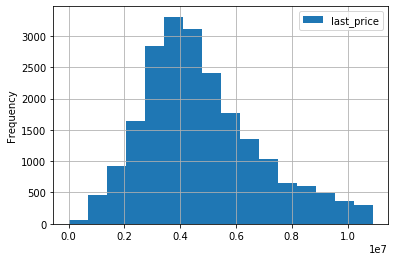

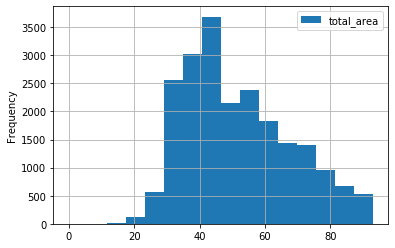

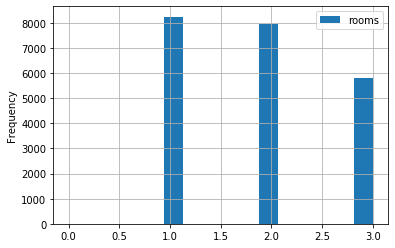

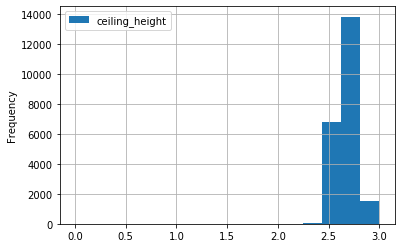

In [ ]:
#изучены следующие параметры: площадь, цена, число комнат, высота потолков
#построены гистограммы для каждого параметра
data['square_meter_price'] = data['last_price']/data['total_area']

columns_list = ['last_price','total_area', 'rooms', 'ceiling_height']
for column in columns_list:
       data.plot(kind='hist', y=column, range=(0, data[column].quantile(0.9)), bins=16, grid=True)
plt.show()

- Построил гистограммы отображающие типичные характеристики квартир по стоимости, площади, кол-ву комнат и высоте потолков

  - типичный прайс от 2 до 7 млн.
  - типичная площадь от 30 до 80 кв.м.
  - типичная квартира от 1 до 3-х комнат.
  - типичная высота потолков от 2.5 до 3-х метров.
  

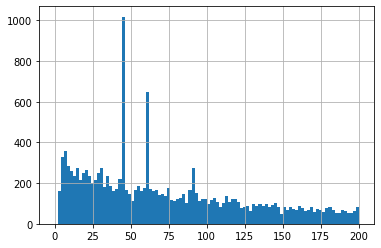

In [ ]:
#"Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. 
#Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
data['days_exposition'].hist(bins=100, range=(0,200)) # 1/2 продается за полгода, 1/4 за год, 1/4  в течении 3-х лет
plt.show()
data['days_exposition'] = data['days_exposition'].drop(data[data['days_exposition']==45].index, axis = 0)
data['days_exposition'] = data['days_exposition'].drop(data[data['days_exposition']==60].index, axis = 0)

#print(data['days_exposition'].describe())# Быстрая продажа это меньше месяца, медленная - больше полугода


<font color='blue'>Давай посмотрим эту гистограмму на масштабе до 200 дней на 100 корзин. Видим ли мы что-то необычное?

Построил гистограмму для анализа скорости продажи квартир
 - 1/2 продается за полгода, 1/4 за год, 1/4  в течении 3-х лет 
 - Быстрая продажа это меньше месяца, медленная - больше полугода
 - Обнаружил резкое увеличение продаж на 45, 60 и 90 день. Странно, что при точном подсчете строк, посчиталость только для 60 дней.

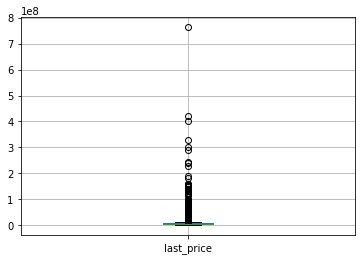

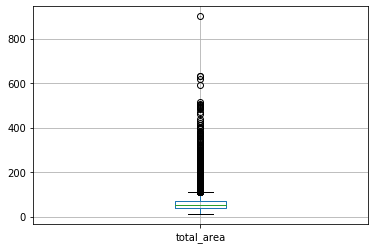

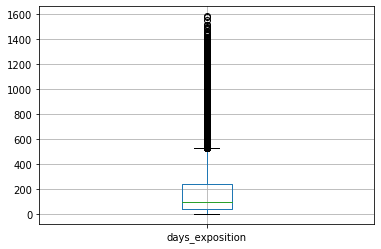

In [ ]:
#"Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
data.boxplot(column='last_price') # В нормальные значения попадают квартиры со стоимостью до 12 млн(много выбросов схлопываю диаграмму) 
plt.show()
data.boxplot(column='total_area')
plt.show()
data.boxplot(column='days_exposition')
plt.show()
#data_good = data.query('last_price<11900000 and total_area<114 and days_exposition<512')
data = data.query('last_price<100000000 and total_area<400 and days_exposition<1200')
#print(len(data_good)/len(data))
#print(data.describe())


Убрал редкие и выбивающиеся данные 
  - Ликвидные значения взял все, которые входят в ящик вместе с усами 
  - Получилось, что осталось 73% от исходного объема данных. Понемногу увеличивал диапазон среза. Заметил, что после 86% увеличение диапазона среза почти не влияет на изменение объема данных. Остановился на этом срезе.

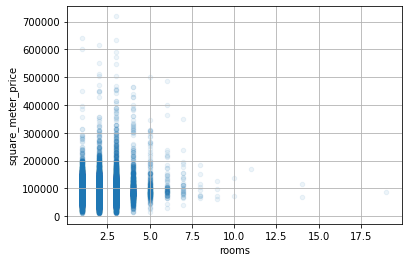

Коэффициент корреляции 0.002346016781624881


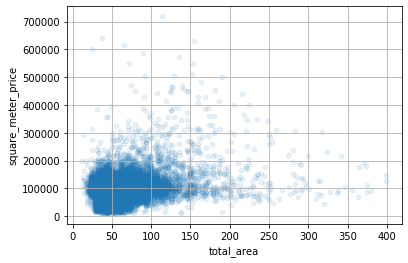

Коэффициент корреляции 0.23322169677578078


,square_meter_price,total_area,rooms
square_meter_price,1,0.233222,0.00234602
total_area,0.233222,1,0.7856
rooms,0.00234602,0.7856,1


In [ ]:
import numpy as np

#Построить зависимость цена кв.метр от числа комнат
data.plot(x='rooms', y='square_meter_price', kind='scatter', alpha=0.08, grid=True)
plt.show()
print('Коэффициент корреляции', data['rooms'].corr(data['square_meter_price']))
#data.plot(x='rooms', y='square_meter_price', kind='hexbin', gridsize=15, sharex=False, grid=True)
#plt.show()

#Построить зависимость цена кв.метр от площади 
#data.plot(x='total_area', y='square_meter_price', kind='hexbin', gridsize=15, sharex=False, grid=True)
#plt.show()
data.plot(x='total_area', y='square_meter_price', kind='scatter', alpha=0.1, grid=True)
plt.show()
print('Коэффициент корреляции', data['total_area'].corr(data['square_meter_price']))
data_for_cor = data[['square_meter_price', 'total_area', 'rooms']]
data_for_cor.corr().style.background_gradient(cmap='coolwarm')

- Построил графики зависимоти стоимости кв.метра от кол-ва комнат и площади:
  - Кол-во комнат почти не влияет на стоимость кв.метра (цена немного падает при увеличениии комнат)
  - Есть зависимость, что с ростом общей площади растет цена кв.метра

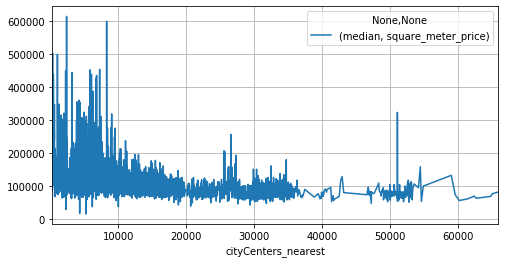

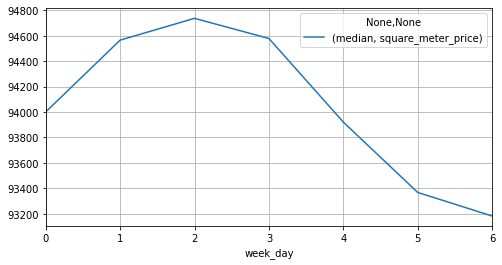

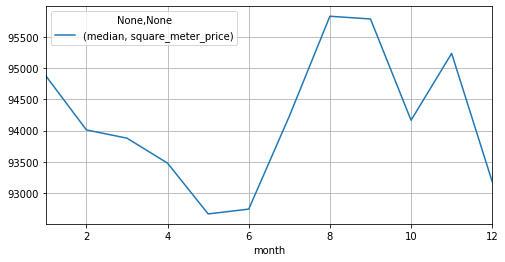

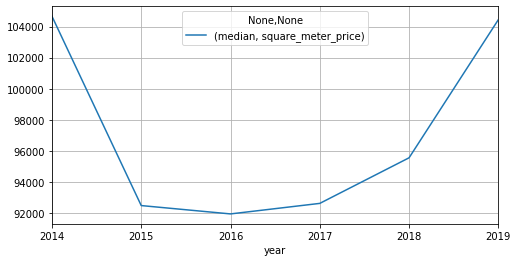

In [ ]:
#Построить зависимость цена кв.метр от удаленности от центра
#data.plot(x='cityCenters_nearest', y='square_meter_price', kind='scatter', alpha=0.1)
#plt.show()
(data
     .pivot_table(index=['cityCenters_nearest'], values=['square_meter_price'], aggfunc=['median'])
     .plot(grid=True, figsize=(8, 4))
)
#Построить зависимость цена кв.метр от дня недели
#data.plot(x='week_day', y='square_meter_price', kind='hexbin', gridsize=20, sharex=False)
#plt.show()
(data
    .pivot_table(index=['week_day'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(8, 4))
)
#Построить зависимость цена кв.метр от месяца
#data.plot(x='month', y='square_meter_price', kind='hexbin', gridsize=20, sharex=False)
#plt.show()
(data
    .pivot_table(index=['month'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(8, 4))
)
#print(data_month)
#Построить зависимость цена кв.метр от года
#data.plot(x='year', y='square_meter_price', kind='hexbin', gridsize=25, sharex=False, grid=True)
#plt.show()
(data
     .pivot_table(index=['year'], values=['square_meter_price'], aggfunc=['median'])
     .plot(grid=True, figsize=(8, 4))
)

 Построил зависимости
- чем ближе к центру, тем дороже. Есть всплески стоимости на расстоянии 25000 и 50000.
- пик продаж по высокому ценнику в среду
- с января по май стоимость квадратного метра падает, затем с июля по сентябрь резкий подъем стоимости. 
Самый дорогой ценник в августе.
- стоимость квартир сильно упала с 2014 к 2015 году, затем видим поступательно растет с 2016 по 2019. С 2015 по 2017 цена не сильно менялась.А в 2018 стоимость выросла на 5% и в 2019 еще на 8,5%.

In [ ]:
#Построить зависимость цена кв.метр от этажа(первый или последний)
data_floor_type = (
    data.pivot_table(index=['floor_type'], values=['square_meter_price'], 
                     aggfunc=['min','mean','median','max']).reset_index()
)
print(data_floor_type.head())

  floor_type                min               mean             median  \
             square_meter_price square_meter_price square_meter_price   
0     другой       10465.116279      101485.686258       97297.297297   
1     первый        9615.384615       80705.909797       80496.172772   
2  последний        7962.962963       89945.842985       87500.583333   

                 max  
  square_meter_price  
0      719298.245614  
1      390625.000000  
2      600000.000000  


- Как и ожидалось, на первом этаже самые дешевые квартиры 

In [ ]:
#Построить зависимость цена кв.м в 10-и населенных пунктах с самым большим кол-вом обьявлений locality_name
top_cities = data['locality_name'].value_counts().head(11)
top = (data
           .query('locality_name in @top_cities.index and locality_name!="санкт-петербург"')
           .groupby('locality_name').mean()['last_price'].astype(int)
)

print(top.sort_values(ascending=False))

locality_name
пушкин               6181804
посёлок парголово    4336759
петергоф             4217730
деревня кудрово      4186526
посёлок шушары       4017850
колпино              3888186
всеволожск           3651524
посёлок мурино       3644810
гатчина              3312835
выборг               3015282
Name: last_price, dtype: int64


Изучил стоимость жилья в 10 городах с самым большим количеством объявлений
   - самое дорогое жилье в г.Пушкин(исключая СПб)
   - самое дешевое - в г.Выборг

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


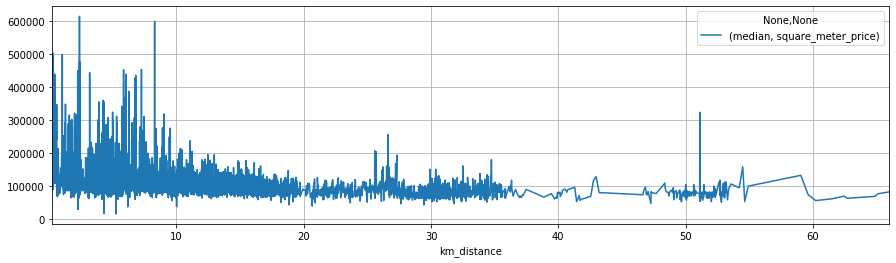

In [ ]:
#"Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. 
#Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр.
#Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. 
#После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от 
#удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
#def center_flat(center_nearest):
#    if 0 < center_nearest < 7000:
#        return '1'
#    else:
#        return '0'
#data['center_flats'] = data['cityCenters_nearest'].apply(center_flat).astype('float64')
#print(data['center_flats'].value_counts())  # Значение совпадает с кол-вом квартир
#data.info()

#data = data[data['center_flats']==1]
#data.plot(x='cityCenters_nearest', y='square_meter_price', kind='scatter', alpha=1)
#plt.show()
#data.plot(x='cityCenters_nearest', y='square_meter_price', kind='hexbin', gridsize=15, sharex=False, grid=True)
#plt.show()
#data['last_price'].hist(bins=50, range=(0,15000000))#типичный прайс от 2 до 7 млн.
#plt.show()
#data_dd = data.pivot_table(index=['cityCenters_nearest'], values=['square_meter_price'], aggfunc=['median'])


data['km_distance'] = ((data['cityCenters_nearest'])/1000).round()

#data['km_distance'] = pd.to_numeric(data['km_distance'], downcast='integer', errors='ignore')
(data
    .pivot_table(index=['km_distance'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(15, 4))
)
#                     

Построил график зависимости стоимость кв.м. от удаления от центра, увидел две особенности:
   - видим резкое уменьшение стоимости после 10км. от центра

In [ ]:
#"Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат,
#высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, 
#дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
#Выбрать сегмент типичных от 1000квартир в центре и за городом. Сравнить корреляцию основных факторов с ценой по всей выборке
#def segment(row):
#    if row['locality_name']=='санкт-петербург':
#        if row['total_area'] >= 56 or row['rooms'] > 2:
#            return 'большие квартиры в центре'
#        elif row['total_area'] >= 40 and row['total_area'] < 56 or 1<row['rooms']<=2:
#            return 'средние квартиры в центре'
#        elif row['total_area'] < 40 or row['rooms'] ==1:
#            return 'маленькие квартиры в центре'
#    if row['locality_name'] != 'санкт-петербург':
#        if row['total_area'] >= 56 or row['rooms'] > 2:
#            return 'большие квартиры за городом'
#        elif row['total_area'] >= 40 and row['total_area'] < 56 or 1<row['rooms']<=2:
#            return 'средние квартиры за городом'
#        elif row['total_area'] < 40 or row['rooms'] ==1:
#            return 'маленькие квартиры за городом'
#    else:
#        return 'неизвестно'
#data['segments'] = data.apply(segment, axis = 1)
#print(data['segments'].value_counts())
#
#data_segments = (
#    data.pivot_table(index=['segments'], values=['square_meter_price'], 
#                     aggfunc=['min','mean','median','max']).reset_index()
#)
#
#print(data_segments.head(6))

#data['living_area'].hist(bins=100, range=(0,100))
#plt.show()
#data['kitchen_area'].hist(bins=50, range=(0,50))
#plt.show()

 Сделал выборку квартир в зависимости от площади, комнат и город или загород
   - стоимость кв.м. в больших квартирах не сильно отличается в городе и за городом, а вот в средних где-то на 8-10% отличается
   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    15753
1     4091
Name: center_flats, dtype: int64
Доля квартир в центре от общего числа: 21%


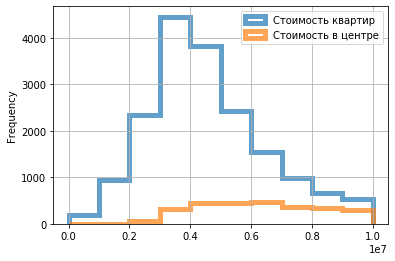

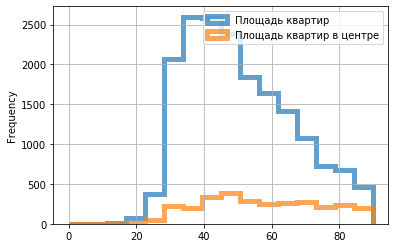

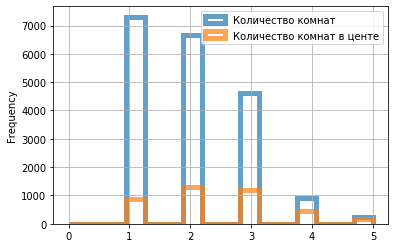

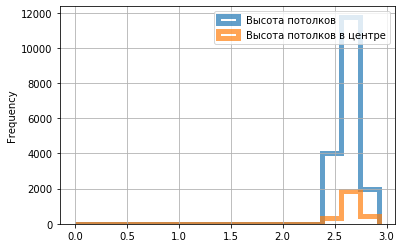

In [ ]:
#"Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат,
#высота потолков. 
def center_flat(center_nearest):    
    if 0 < center_nearest < 10:
        return '1'
    else:
        return '0'
data['center_flats'] = data['km_distance'].apply(center_flat).astype(int)
print(data['center_flats'].value_counts())
share_center = len(data[data['center_flats']==1])/len(data['center_flats'])*100
print('Доля квартир в центре от общего числа: {:.0f}%'.format(share_center))


data['square_meter_price'] = data['last_price']/data['total_area']
ax_1=(data
          .plot(kind='hist', y='last_price', histtype='step', linewidth=5, alpha=0.7,
           range=(0, data['last_price'].quantile(0.9)), label='Стоимость квартир', grid=True, legend=True)
)
(data
  .query('center_flats==1')
  .plot(kind='hist', y='last_price', histtype='step', linewidth=5, alpha=0.7,
range=(0, data['last_price'].quantile(0.9)), label='Стоимость в центре', ax=ax_1, grid=True, legend=True) 
)
plt.show()
ax_2=(data
     .plot(kind='hist', y='total_area', histtype='step', linewidth=5, alpha=0.7,
      range=(0, data['total_area'].quantile(0.9)), bins=16, label='Площадь квартир', grid=True)
)
(data
.query('center_flats==1')
.plot(kind='hist', y='total_area', histtype='step', linewidth=5, alpha=0.7,
range=(0, data['total_area'].quantile(0.9)), bins=16, label='Площадь квартир в центре', ax=ax_2, grid=True, legend=True)
)
plt.show()
ax_rooms=(data
    .plot(kind='hist', y='rooms', histtype='step', linewidth=5, alpha=0.7, 
     range=(0, data['rooms'].quantile(0.99)), bins=16, label='Количество комнат', grid=True)
)
(data
.query('center_flats==1')
.plot(kind='hist', y='rooms', histtype='step', linewidth=5, alpha=0.7,
range=(0, data['rooms'].quantile(0.99)), bins=16, label='Количество комнат в центе', ax=ax_rooms, grid=True, legend=True)
)
plt.show()
ax_ceil=(data
     .plot(kind='hist', y='ceiling_height', histtype='step', linewidth=5, alpha=0.7, 
      range=(0, data['ceiling_height'].quantile(0.9)), bins=16, label='Высота потолков', grid=True)
)
ax_ceil=(data
.query('center_flats==1') 
.plot(kind='hist', y='ceiling_height', histtype='step', linewidth=5, alpha=0.7, 
range=(0, data['ceiling_height'].quantile(0.9)), bins=16, label='Высота потолков в центре',ax=ax_ceil,grid=True, legend=True)
)
plt.show()

Выделил квартиры в центре и сравнил основные характреристики этих квартир со всеми квартирами:
  - цена кв. метра в среднем более чем в 1.5 раза выше. Стоимость не имеет четкого пика, вверху график плоский.
  - такое же положение с площадью. Равное распределение между кол-вом квартир(от 40кв.м. до 100кв.м.)
  - в отличии от всего города в центре больше 2-х и 3-х комнатных квартир
  - по высоте потолков распределение похоже с общим.

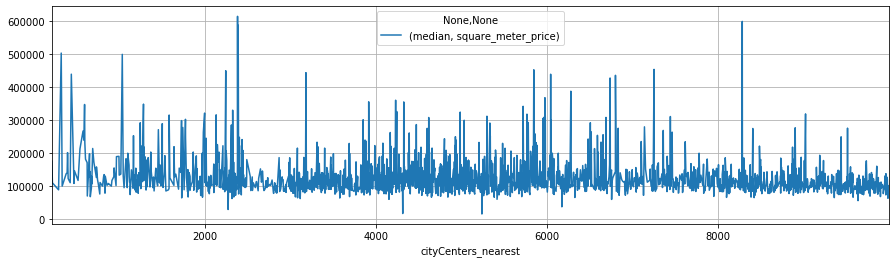

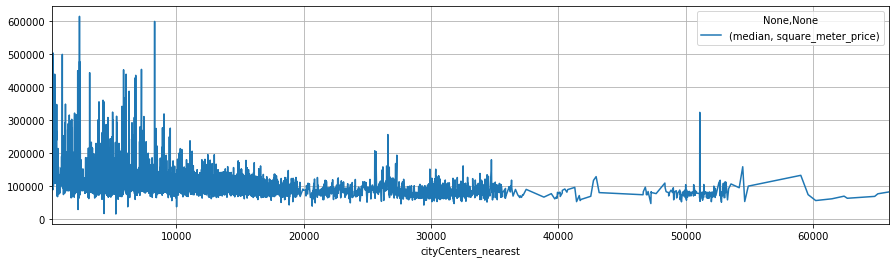

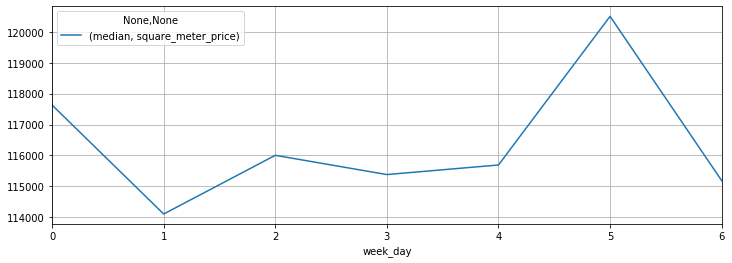

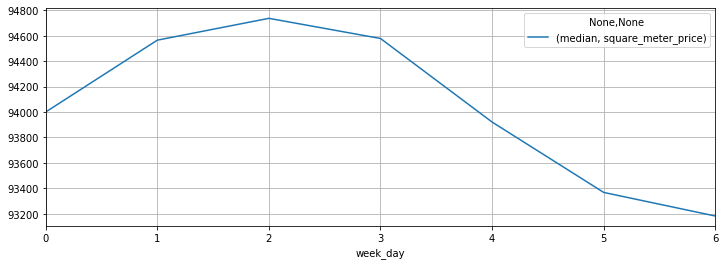

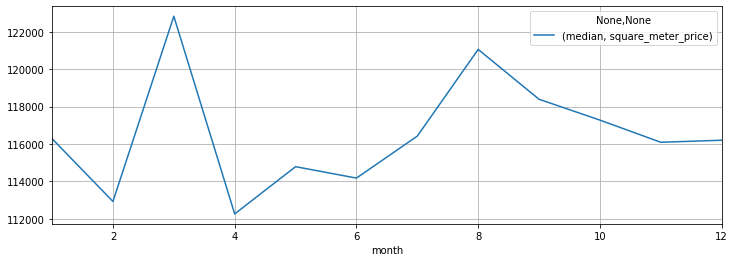

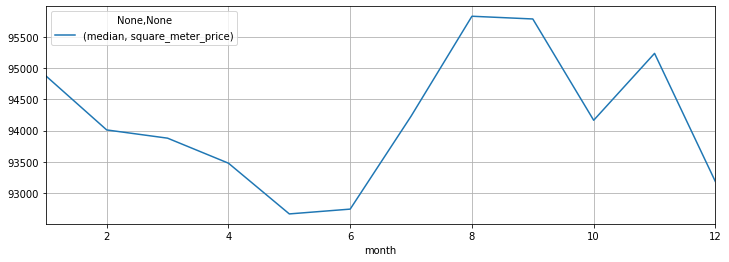

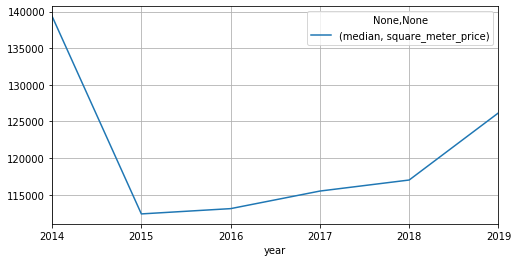

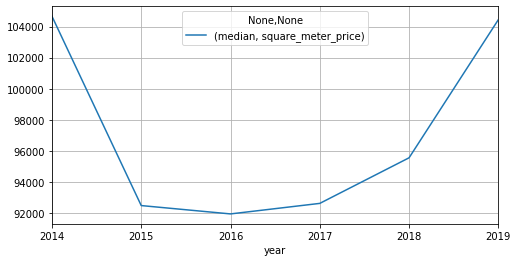

In [ ]:
#Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, 
#дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"

(data
     .query('center_flats==1')
     .pivot_table(index=['cityCenters_nearest'], values=['square_meter_price'], aggfunc=['median'])
     .plot(grid=True, figsize=(15, 4))
)
(data
     .pivot_table(index=['cityCenters_nearest'], values=['square_meter_price'], aggfunc=['median'])
     .plot(grid=True, figsize=(15, 4))
)
#Построить зависимость цена кв.метр от дня недели
(data
    .query('center_flats==1')
    .pivot_table(index=['week_day'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(12, 4))
)
(data
    .pivot_table(index=['week_day'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(12, 4))
)
#Построить зависимость цена кв.метр от месяца
(data
    .query('center_flats==1')
    .pivot_table(index=['month'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(12, 4))
)
(data
    .pivot_table(index=['month'], values=['square_meter_price'], aggfunc=['median'])
    .plot(grid=True, figsize=(12, 4))
)
#Построить зависимость цена кв.метр от года
(data
     .query('center_flats==1')
     .pivot_table(index=['year'], values=['square_meter_price'], aggfunc=['median'])
     .plot(grid=True, figsize=(8, 4))
)
(data
     .pivot_table(index=['year'], values=['square_meter_price'], aggfunc=['median'])
     .plot(grid=True, figsize=(8, 4))
)

 Сравнил основные факторы, которые влияют на стоимость квартир в центре с квартирами во всем городе:
    - Стоимость квартир в центре почти не зависит от расстояния до центра. В отличии от общего числа, где   
       ближе к центру цена растет
    - Пик продаж квартир в центре в субботу(возможно в будни люди работают), а квартир во всем городе в   
       среду
    - Параметры стоимости продаж в зависимости от года и месяца примерно одинаковы для квартир в центре 
       и во всем городе

In [ ]:
#Выбрать сегмент типичных от 1000квартир в центре и за городом. Сравнить корреляцию основных факторов с ценой по всей выборке
#площадь, цена, число комнат,высота потолков. 
#выделил типичные квартиры в центре
data_center = (data
.query('center_flats==1 and 4000000<last_price<10000000 and total_area<400 and 1<rooms<4 and days_exposition<1200')
)
#print(len(data_center))#1672
#выделил типичные квартиры за городом
data_out_of_center = (data
              .query('locality_name!="санкт-петербург" and 2000000<last_price<7000000 and 30<total_area<80 and 1<rooms<3 and days_exposition<1200')
)
#print(len(data_out_of_center)) #1894
print('Коэффициент корреляции площади к цене кв.м. в центре', 
       data_center['total_area'].corr(data_center['square_meter_price']))
print('Коэффициент корреляции площади к цене кв.м. за городом', 
       data_out_of_center['total_area'].corr(data_out_of_center['square_meter_price']))
print()
print('Коэффициент корреляции количества комнат к цене кв.м. в центре', 
       data_center['rooms'].corr(data_center['square_meter_price']))
print('Коэффициент корреляции количества комнат к цене кв.м. за городом', 
       data_out_of_center['rooms'].corr(data_out_of_center['square_meter_price']))
print()
print('Коэффициент корреляции стоимости квартиры к цене кв.м. в центре', 
       data_center['last_price'].corr(data_center['square_meter_price']))
print('Коэффициент корреляции стоимости к цене кв.м. за городом', 
       data_out_of_center['last_price'].corr(data_out_of_center['square_meter_price']))
print()
print('Коэффициент корреляции длительности к цене в центре', 
       data_center['days_exposition'].corr(data_center['last_price']))
print('Коэффициент корреляции длительности к цене за городом', 
       data_out_of_center['days_exposition'].corr(data_out_of_center['last_price']))
print()
print('Коэффициент корреляции высоты потолков к цене кв.м. в центре', 
       data_center['ceiling_height'].corr(data_center['square_meter_price']))
print('Коэффициент корреляции высоты потолков к цене кв.м. за городом', 
       data_out_of_center['ceiling_height'].corr(data_out_of_center['square_meter_price']))
data_for_corr = data[['square_meter_price', 'total_area', 'rooms', 'last_price', 'days_exposition', 'ceiling_height']]
data_for_corr.corr().style.background_gradient(cmap='coolwarm')


Коэффициент корреляции площади к цене кв.м. в центре -0.35988583552012354
Коэффициент корреляции площади к цене кв.м. за городом 0.009079504857505692

Коэффициент корреляции количества комнат к цене кв.м. в центре -0.402952060604356
Коэффициент корреляции количества комнат к цене кв.м. за городом nan

Коэффициент корреляции стоимости квартиры к цене кв.м. в центре 0.4443043649584929
Коэффициент корреляции стоимости к цене кв.м. за городом 0.837904515967952

Коэффициент корреляции длительности к цене в центре 0.10490508762451216
Коэффициент корреляции длительности к цене за городом 0.01175418663060661

Коэффициент корреляции высоты потолков к цене кв.м. в центре 0.04300184893973754
Коэффициент корреляции высоты потолков к цене кв.м. за городом 0.07349550165864016


,square_meter_price,total_area,rooms,last_price,days_exposition,ceiling_height
square_meter_price,1,0.233222,0.00234602,0.719359,0.0391753,0.239475
total_area,0.233222,1,0.7856,0.757052,0.14913,0.329613
rooms,0.00234602,0.7856,1,0.469069,0.120499,0.189771
last_price,0.719359,0.757052,0.469069,1,0.115881,0.325959
days_exposition,0.0391753,0.14913,0.120499,0.115881,1,0.0898944
ceiling_height,0.239475,0.329613,0.189771,0.325959,0.0898944,1


 Сравнил коэффициент корреляции основных параметров типичных квартир в центре и за городом:
    - в центре есть сильная зависимость, что с ростом площади прайс метра падает. За городом такого почти не наблюдается
    - в центре чем больше комнат, тем ниже стоимость кв.метра. За городом не нашел зависимость
    - в центре зависимость общей стоимости от стоимости кв.метра в 2 раза выше, чем за городом
    - длительность продажи почти не влияет на стоимость
 

### Шаг 5. Общий вывод

1. Выявил типичные параметры продаваемых квартир:
 - прайс от 2 до 7 млн.руб.
 - площадь от 30 до 80 кв.м.
 - от 1 до 3 комнат в квартире
 - высота потолков от 2.5 до 3-х метров
2. Изучил время продажи квартиры:
 - среднее время продажи - полгода
 - продажа меньше недели - быстрая
 - продажа больше года - долгая
 - график продаж похож на распределение Пуассона
 - Обнаружил резкое увеличение продаж на 45, 60 и 90 день. Странно, что при точном подсчете строк, посчиталость только для 60 дней.
3. Убрал редкие и выбивающиеся значения. 
   - Сделал срез по ключевым параметрам(прайс, общая площадь и длительность продажи). 
   - Получилось, что осталось 73% от исходного объема данных. Понемногу увеличивал диапазон среза. Заметил, что после 86% увеличение диапазона среза почти не влияет на изменение объема данных. Остановился на этом срезе
4. Изучил зависимости:
   - цена кв.метр от площади квартиры.
     Чем меньше площадь, тем дороже. Самый дорогой до 40кв.м. , потом до 60кв.м., потом 70 и 80.
   - цена кв.метр от числа комнат. Самый дорогой кв.м. в однушках, чем больше комнат тем дешевле. В продаже больше всего 2-шек, 1 и 3-х комнатных примерно проровну
   - цена кв.метр от этажа. Самая дешевая среди всех на последнем этаже.
     В среднем самые дешевые квартиры на первых этажах, потом последний этаж, а потом все остальные.
   - цена кв.метр от удаленности от центра.
   
5. Построил зависимости
   - Чем ближе к центру тем дороже. Есть всплески стоимости на расстоянии 25000 и 50000.
   - цена кв.метр от дня недели. Самые дорогие продажи в среду.
   - с января по май стоимость квадратного метра падает, затем с июля по сентябрь резкий подъем стоимости. Самый дорогой ценник в августе.
   - стоимость квартир сильно упала с 2014 к 2015 году, затем видим поступательно растет с 2016 по 2019. С 2015 по 2017 цена не сильно менялась.А в 2018 стоимость выросла на 5% и в 2019 еще на 8,5%.

6. Из ТОП-10 городов с самым большим кол-вом продаваемых квартир:
   - самое дорогое жилье в г.Пушкин(исключая СПб)
   - самое дешевое - в г.Выборг
   
7. Построил график зависимости стоимость кв.м. от удаления от центра, увидел две особенности:
   - видим резкое уменьшение стоимости после 10км. от центра

8. Сделал выборку квартир в зависимости от площади, комнат и город или загород
   - стоимость кв.м. в больших квартирах не сильно отличается в городе и за городом, а вот в средних где-то на 8-10% отличается

9. Выделил квартиры в центре и сравнил основные характреристики этих квартир со всеми квартирами:
   - цена кв. метра в среднем более чем в 1.5 раза выше. Стоимость не имеет четкого пика, вверху график плоский.
   - такое же положение с площадью. Равное распределение между кол-вом квартир(от 40кв.м. до 100кв.м.)
   - в отличии от всего города в центре больше 2-х и 3-х комнатных квартир
   - по высоте потолков распределение похоже с общим.
   
10. Сравнил основные факторы, которые влияют на стоимость квартир в центре с квартирами во всем городе:
    -  Стоимость квартир в центре почти не зависит от расстояния до центра. В отличии от общего числа, 
       где ближе к центру цена растет
    - Пик продаж квартир в центре в субботу(возможно в будни люди работают), а квартир во всем 
       городе в среду
    - Параметры стоимости продаж в зависимости от года и месяца примерно одинаковы для квартир в центре 
      и во всем городе
   
11. Сравнил коэффициент корреляции основных параметров типичных квартир в центре и за городом:
    - в центре есть сильная зависимость, что с ростом площади прайс метра падает. За городом такого 
      почти не наблюдается
    - в центре чем больше комнат, тем ниже стоимость кв.метра. За городом не нашел зависимость
    - в центре зависимость общей стоимости от стоимости кв.метра в 2 раза выше, чем за городом
    - длительность продажи почти не влияет на стоимость

